In [2]:
import pandas as pd
import json
import os
import glob
import datetime
import matplotlib.pyplot as plt
import numpy as np
import re 
from num2words import num2words
from cmath import isnan
from whisper_normalizer.english import EnglishTextNormalizer
from helper_functions import *
# from remove_duplicates import *
from io import StringIO
import zipfile


pd.options.display.max_rows = 100000000
pd.options.display.max_colwidth = None

In [ ]:
def convert_json_to_csv(json_file,ASR_column_name):
    """
    Convert json file to csv file.
    """
    with open(json_file) as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    # change column name if the column name is segment_name, change it to filename
    if "segment_name" in df.columns:
        df = df.rename(columns={"segment_name":"filename"})
    
    if "aws_transcription" in df.columns:
        df = df.rename(columns={"aws_transcription":"transcript"})

    if "azure_transcription" in df.columns:
        df = df.rename(columns={"azure_transcription":"transcript"})

    if "job_id" in df.columns:
        # remove this column
        df = df.drop(columns=["job_id"])
    df["ASR"] = ASR_column_name

    # remove duplicates if there are any files that have the same entries for filename and ASR columns
    df = df.drop_duplicates(subset=["filename","ASR"])
    # print the number of rows
    print("Number of rows in this file is...",df.shape[0])
    return df


FOLDER_PATH = './../../data/ASR_Transcripts/'
# create a panda
dfs= pd.DataFrame()
for file in os.listdir(FOLDER_PATH):

    if file.endswith('.json'):
        if "transcript" in file:
            print(file)
            # detect model name in file name 
            model_name = file.split("_")[2]
            # join path
            file = os.path.join(FOLDER_PATH,file)
            df = convert_json_to_csv(file,model_name)
            if dfs.empty:
                dfs = df
            else:
                # merge dfs
                dfs = pd.concat([dfs,df])
            # create a new column for group
            
            
# remove deplicate rows
dfs = dfs.drop_duplicates()

# drop index column 
# sort dataframe by filename
dfs = dfs.sort_values(by=['filename'])


# pivot dataframe from ASR column to wide format
df_wide = dfs.pivot_table(index='filename', columns='ASR', values='transcript', aggfunc='first')


# replace empty output with NAs
df_wide["RevAI"] = df_wide["RevAI"].replace("FAILED (n/a)","")
df_wide = df_wide.replace(r'^\s*$', pd.NA, regex=True)

# count how many files each ASR failed to transcribe
print("The number files each ASR failed to transcribe:")
print(df_wide.isnull().sum())

# output to csv
df_wide.head(10)
date = str(datetime.datetime.now().date())
# df_wide.to_csv(date+'_transcript.csv')    

Check output results from second time of running ASR

In [ ]:

FOLDER_PATH = './../../data/ASR_Transcripts/Rerun_results/'
# create a panda
dfs_2= pd.DataFrame()
for file in os.listdir(FOLDER_PATH):

    if file.endswith('.json'):
        if "transcript" in file:
            # detect model name in file name 
            print(file)
            model_name = file.split("_")[1]
            # join path
            file = os.path.join(FOLDER_PATH,file)
            df2 = convert_json_to_csv(file,model_name)
            if dfs_2.empty:
                dfs_2 = df2
            else:
                # merge dfs
                dfs_2 = pd.concat([dfs_2,df2])
            # create a new column for group

# drop NA rows
# replace empty output with NAs
dfs_2 = dfs_2.replace(r'^\s*$', pd.NA, regex=True)
dfs_2 = dfs_2.drop_duplicates()
# dfs_2 = dfs_2.dropna(subset=["transcript"])
# rename column transcript to transcript2
dfs_2 = dfs_2.rename(columns={"transcript":"transcript2"})

# replace empty output with NAs

# left join dfs_2 to dfs
dfs_3 = dfs.merge(dfs_2,how="left",on=["filename","ASR"])


In [4]:
dfs["transcript"] = dfs["transcript"].replace(r'^\s*$', pd.NA, regex=True)

# fill in the missing values in transcript column with the values in transcript2 column
dfs_3["transcript"] = dfs_3["transcript"].fillna(dfs_3["transcript2"]) 


In [5]:
dfs_3 = dfs_3.drop(columns=["transcript2"])
# pivot dataframe from ASR column to wide format
dfs_3= dfs_3.drop_duplicates().reset_index(drop=True)

df_wide = dfs_3.pivot_table(index='filename', columns='ASR', values='transcript', aggfunc='first')

# pivot dataframe from ASR column to wide format

# replace empty output with NAs
df_wide["RevAI"] = df_wide["RevAI"].replace("FAILED (n/a)","")
# Assuming 'asr_data' is a DataFrame
df_wide["Azure"] = df_wide["Azure"].replace("No speech could be recognized", "", regex=True).astype(str)

df_wide = df_wide.replace(r'^\s*$', pd.NA, regex=True)

# count how many files each ASR failed to transcribe
print("The number files each ASR failed to transcribe:")
print(df_wide.isnull().sum())

# count number of rows in each ASR
print("The number of rows in each ASR:")
print(df_wide.count())



The number files each ASR failed to transcribe:
ASR
AWS                 120
AssemblyAI          401
Azure               210
GoogleChirp         678
GoogleLong          434
GoogleTelephony     374
RevAI              1987
Whisper             121
dtype: int64
The number of rows in each ASR:
ASR
AWS                13860
AssemblyAI         13579
Azure              13770
GoogleChirp        13302
GoogleLong         13546
GoogleTelephony    13606
RevAI              11993
Whisper            13859
dtype: int64


In [6]:
# remove dfs_2 and dfs_3 from memory
del dfs_2
del dfs_3

In [7]:

# Check current directory and see if this entails paths to data
current_dir_path = "../data"

# set current directory to data if not already there
if os.getcwd() != current_dir_path:
    os.chdir(current_dir_path)
    
# set output filename 
OUTPUT_FILENAME = str(datetime.date.today())+"_WER_Results.csv"

print(OUTPUT_FILENAME)

2025-04-04_WER_Results.csv


Read in ground truth data 

In [ ]:
aphasia_groundtruth = pd.read_csv("./../../data/Ground_Truth_Transcript/aphasia_nounk_over3_2024-03-07.csv")
control_groundtruth = pd.read_csv("./../../data/Ground_Truth_Transcript/control_nounk_over3_2024-03-07.csv")

aphasia_groundtruth['Group'] = 'aphasia'
control_groundtruth['Group'] = 'control'
# merge aphasia and control groundtruth and select only segment_name and clean
groundtruth = pd.concat([aphasia_groundtruth,control_groundtruth])
groundtruth.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'filename', 'raw_transcript',
       'start_time', 'end_time', 'segment_name', 'duration', 'clean',
       'clean_v1', 'clean_v2', 'clean_v3', 'word_count_v2', 'Group'],
      dtype='object')

In [9]:
groundtruth.head(2)

,Unnamed: 0.1,Unnamed: 0,filename,raw_transcript,start_time,end_time,segment_name,duration,clean,clean_v1,clean_v2,clean_v3,word_count_v2,Group
0,8,8,tucson08b.cha,"&-um (.) Cinderella is [//] &-uh (.) lives with a (.) stepmother and &=fingers:two two [/] &+chil &-uh two &+chir children . it was her half sisters . and &-um she (.) cleaned up after them . and they [//] &+s she &+s <got them> [//] &+g &-uh gave them tea . and you_know they +... &-um but they treated her like shit &-um &=covers:mouth you_know . and &-um &=laughs &-um (.) they +... okay ‡ well ‡ she wanted to &+s go to the [/] &-uh the ball . the [/] &-uh (.) the king is having a ball . so ‡ &+h she says +""/. +"" oh ‡ I wish I could go . and she got into &-um (.) the book . and [//] <and she's> [//] when she saw the [//] &-uh in the book she got the &+gr &-uh gown and +... <and &-um so the> [//] &+s and &-um (.) fairy godmother &-um get [//] <got her> [//] &-um make [//] you_know &-um &=ges:wand gave her the wand . and she was all dressed up . and she [//] when she &-uh heard the &-uh twelve o'clock she hadta be back . [+ gram] so ‡ she +... oh and I forgot . [+ exc] &-um the &=ges:small little &-uh &-uh mouse &-um was you_know <I don't know> [//] was &-uh everything there . [+ es] I don't know who's [/] who's anymore . [+ exc] but anyway &-um &-uh (.) okay . [+ exc] so ‡ she got the &-um &-uh (.) midnight . [+ gram] so ‡ she [/] &-uh she left the prince the +... and she's +""/. +"" oh_no ! so ‡ she &+g left him . and she &+w left a &=ges:small glass slipper . and then they [//] &-uh &-um he wanted to find out (.) &~Cinde who Cinderella was . and he was going to every [/] &+har &-um every place to see if the glass slipper . [+ gram] and she went to the [/] the [/] (.) &+m &-uh (.) the stepmother and the two sister [: sisters] [* m:0s] and they wanted to not oh [//] &-uh believe that she was &+d &-uh doing it . [+ cir]",710850,950600,tucson08b_710850_950600.wav,239750,FILLERum Cinderella is FILLERuh lives with a stepmother and two FRAGMENTchil FILLERuh two FRAGMENTchir children it was her half sisters and FILLERum she cleaned up after them and they FRAGMENTs she FRAGMENTs got them FRAGMENTg FILLERuh gave them tea and you know they FILLERum but they treated her like shit FILLERum you know and FILLERum FILLERum they okay well she wanted to FRAGMENTs go to the FILLERuh the ball the FILLERuh the king is having a ball so FRAGMENTh she says oh I wish I could go and she got into FILLERum the book and and she's when she saw the FILLERuh in the book she got the FRAGMENTgr FILLERuh gown and and FILLERum so the FRAGMENTs and FILLERum fairy godmother FILLERum get got her FILLERum make you know FILLERum gave her the wand and she was all dressed up and she when she FILLERuh heard the FILLERuh twelve o'clock she hadta be back so she oh and I forgot FILLERum the little FILLERuh FILLERuh mouse FILLERum was you know I don't know was FILLERuh everything there I don't know who's who's anymore but anyway FILLERum FILLERuh okay so she got the FILLERum FILLERuh midnight so she FILLERuh she left the prince the and she's oh no so she FRAGMENTg left him and she FRAGMENTw left a glass slipper and then they FILLERuh FILLERum he wanted to find out who Cinderella was and he was going to every FRAGMENThar FILLERum every place to see if the glass slipper and she went to the the FRAGMENTm FILLERuh the stepmother and the two sister and they wanted to not oh FILLERuh believe that she was FRAGMENTd FILLERuh doing it,um Cinderella is uh lives with a stepmother and two chil uh two chir children it was her half sisters and um she cleaned up after them and they s she s got them g uh gave them tea and you know they um but they treated her like shit um you know and um um they okay well she wanted to s go to the uh the ball the uh the king is having a ball so h she says oh I wish I could go and she got into um the book and and she's when she saw the uh in the book she got the gr uh gown and and um so the s

Select the column for ground truth 

In [10]:
selected_groundtruth_version = "clean"
groundtruth_data = groundtruth[['segment_name',"clean_v1",selected_groundtruth_version,'Group','duration']]

Correct ground truth

In [11]:
# modify_edgecase_value(groundtruth_data,segment_name="whiteside19a_253560_311953.wav",column_name=selected_groundtruth_version,new_value="that is FILLERuh FILLERuh there was just not much I did that about two two thousand and he he did that FRAGMENTah alright FRAGMENTt FRAGMENTt that FILLERuh they didn't even know I did that they they had the stroke for that FILLERuh I I FILLERuh just just wait a minute September October November December August September October three two thousand and")
# filename = "elman14a_365514_402813.wav"
modify_edgecase_value(groundtruth_data,segment_name="elman14a_365514_402813.wav",column_name=selected_groundtruth_version,new_value="the the the FRAGMENTst stroke when I first got here FILLERuh FILLERuh I have friends FRAGMENTm my my FILLERuh FILLERuh FILLERuh let's see my brother inloss law inloss and his his FILLERuh wife they came to Saint Louis for me just just just for me because my FRAGMENTs my my FRAGMENTs FRAGMENTh husband died in eight let me see nineteen eighty four but in with these people that came to me and they just they got this FRAGMENTf FRAGMENTm just to keeping myself together because they stayed for almost like a month yes FRAGMENTt")
# filename = "aprocsa1738a_548830_556645.wav"
modify_edgecase_value(groundtruth_data,segment_name="aprocsa1738a_548830_556645.wav",column_name=selected_groundtruth_version,new_value="first cousin living in on the beach in FRAGMENTman Hermosa Beach so")
# filename = UNH10c_34648_41638.wav
modify_edgecase_value(groundtruth_data,segment_name="UNH10c_34648_41638.wav",column_name=selected_groundtruth_version,new_value="mhm FILLERum eleven years")

#filename = UNH02b_801390_807950.wav
modify_edgecase_value(groundtruth_data,segment_name="UNH02b_801390_807950.wav",column_name=selected_groundtruth_version,new_value="one two three four five six that’s funny")

#filename = wright87a_20038_60960.wav
modify_edgecase_value(groundtruth_data,segment_name="wright87a_20038_60960.wav",column_name=selected_groundtruth_version,new_value="FILLERum right before FILLERuh FILLERlike the end of the school year I went to a pool party and I got hit into the face with one of those small basketballs where you're playing FILLERlike baseball with it and somebody cracked you know cracked the bat and and it landed right here in my face and I hadta go to the emergency room and they hadta do FILLERum x rays and all of that luckily nothing was broken but I ended up going to a FILLERum plastic surgeon and having five tiny stitches right above my eye in this little tiny space and I had two enormous black eyes for probably about almost four weeks so")

#filename = UNH1051_937355_970257.wav
modify_edgecase_value(groundtruth_data,segment_name="UNH1051_937355_970257.wav",column_name=selected_groundtruth_version,new_value="I growing up only had dogs my first dog was FILLERlike big Labrador and then FILLERum when I was FILLERlike nine I think it passed away her name was Kelsey so for a really long time I thought that the name Kelsey was FILLERlike a dog name FILLERlike FRAGMENTsome FILLERlike something like that so then we had a Scottish terrier named Hunter who passed away when I was FILLERlike a sophomore in college and now my parents have a dog they adopted from the Humane Society and my apartment only allows cats so I got my cat it's my first that's FILLERlike my first my pet")

#filename = capilouto43a_751690_783129.wav
modify_edgecase_value(groundtruth_data,segment_name="capilouto43a_751690_783129.wav",column_name=selected_groundtruth_version,new_value="mom's trying to talk Junior into taking an umbrella out he's typical young lad he's he knows more than mom so he takes off without the umbrella gets part way on his way I assume to school and believe it or not it starts to rain looks like he makes a one eighty and heads back to the barn and FILLERuh mom's upset with him he's soaking wet but believe it or not he thought he'd be better off going to school using the umbrella")

# filename=wright06a_862152_892733.wav
modify_edgecase_value(groundtruth_data,segment_name="wright06a_862152_892733.wav",column_name=selected_groundtruth_version,new_value="FILLERum I went to Europe I went on a cruise FILLERum to to Italy, and Greece, and Turkey for two weeks on FILLERum Carnival and I had a great time I saw the Acropolis and I went to Turkey and saw Ephesus a city dug out of FILLERum the dirt it was dug out in nineteen fifty five and FILLERum is that enough or more")

# filename = UNH1018_1585664_1610520.wav
modify_edgecase_value(groundtruth_data,segment_name="UNH1018_1585664_1610520.wav",column_name=selected_groundtruth_version,new_value="a rugby team consists of eight members of the forward section of the team so there's forwards and backs there's two different sections of each team FILLERuh generally it's eight and seven, I think, or eight and eight one of those two I don't remember exactly the number it's one it's either eight or seven for each side so eight people in the scrum so that's the forwards the forwards are all everyone who gets into the scrum so whenever there's a penalty or the ball gets kicked, FILLERuh FILLERuh the play stops while the ball is on the field so that it doesn't get kicked out of bounds")

# filename = capilouto47a_115190_140030.wav
modify_edgecase_value(groundtruth_data,segment_name="capilouto47a_115190_140030.wav",column_name=selected_groundtruth_version,new_value="FILLERuh two and a half three years ago now my appendix ruptured and I didn't realize it for several days so by the time I went to the doctor to the hospital I was pretty sick lad so I had FRAGMENTsurg I went into the hospital at noon I was on the operating table at seven and I got out of the hospital thirteen days later")

# capilouto34a_346304_369519.wav
modify_edgecase_value(groundtruth_data,segment_name="capilouto34a_346304_369519.wav",column_name=selected_groundtruth_version,new_value="the first story is that the kid's out kicking a soccer ball and FILLERuh he kicks it through the window of a house breaks the window goes in and and lands in his FRAGMENTm I guess it's his dad's lap and the dad picks up the ball looks out the window FILLERuh to see where the ball came from and undoubtedly it was from his son")

# filename = UNH1018_446968_468093.wav
modify_edgecase_value(groundtruth_data,segment_name="UNH1018_446968_468093.wav",column_name=selected_groundtruth_version,new_value="there are two of them I could probably beat them in a rough but I didn't want to try it because they were faster than me and I was also far enough away where I wasn't sure I could get to it before they could because they were already on top of him so he looked back and FILLERuh later on I found out he didn't even know who was behind him he was just throwing it to get rid of it and hope that someone on the team was there and I happened to be there so they both tackled him instead of leaving one guy up to take care of the hurricane behind him")

# filename =kurland13a_1073615_1087881.wav
modify_edgecase_value(groundtruth_data,segment_name="kurland13a_1073615_1087881.wav",column_name=selected_groundtruth_version,new_value="FRAGMENTup FRAGMENTup upon a time alright he did was FILLERuh FRAGMENTs FRAGMENTs FRAGMENTs FRAGMENTs FRAGMENTs Cinderella")
# filename = UMD14_70336_106234.wav
modify_edgecase_value(groundtruth_data,segment_name="UMD14_70336_106234.wav",column_name=selected_groundtruth_version,new_value="mama said to the little boy it's supposed to rain today take your umbrella with you to school and the little boy says ah no I don't need an umbrella it's not gonna rain on me and then he walks to school and it starts to rain and it rains really hard and he's all soaking wet and he's not happy and his mother's not happy either and he hasta change clothes probably it's hard to tell and then he gets to walk to school with the umbrella")

# filename = kansas05a_96506_110736.wav
modify_edgecase_value(groundtruth_data,segment_name="kansas05a_96506_110736.wav",column_name=selected_groundtruth_version,new_value="I am I'm dead noone could see anything couldn't see me for three FRAGMENTmen three outs no three FRAGMENTd twelve")

# filename = scale06a_122696_188806.wav
modify_edgecase_value(groundtruth_data,segment_name="scale06a_122696_188806.wav",column_name=selected_groundtruth_version,new_value="FILLERum FILLERum Piper, that's my wife, she does all the talking but FILLERum no that's not true FILLERum hundreds of tests for me speech and therapy and exercise and I did it all the Boston something I did it all FILLERuh FRAGMENTfi FILLERuh four years year, yeah FILLERum and still progress and I'm getting annoying because FILLERuh I said enough is enough with FILLERuh all the testing with FILLERum the FRAGMENTsc")

# filename = whiteside20a_365110_414956.wav
modify_edgecase_value(groundtruth_data,segment_name="whiteside20a_365110_414956.wav",column_name=selected_groundtruth_version,new_value="FILLERum and which I was aware of that too this wasn't quite right because he's not what I'm hearing to myself is not what's happening either but it's like it was the weirdest thing to be held up and you can't even sit up still so that's kinda where it where it was so then of course my son he woke up my son and then the two of them took me in the car over to the hospital which was only FILLERuh FILLERum a block couple blocks away really which too bad if I would have known that or had a sense in my head that oh I might need some help but that's not me so that's usually I'm gonna solve it and I'm gonna take care of it and it's no big deal and he's a military guy so I did my own stuff typical hi")
# filename = scale21a_534630_587300.wav
modify_edgecase_value(groundtruth_data,segment_name="scale21a_534630_587300.wav",column_name=selected_groundtruth_version,new_value="so the boy is outside and he's playing soccer and apparently he must have hit he kicked the ball too hard and went into his next door neighbor's FILLERum FRAGMENTgl FILLERum house it broke the glass and the FILLERum it it comes by it comes in to the FRAGMENTm the neighbor's house and knocks over the lamp and the man FRAGMENTh happens happened to be sitting beside it and sees the ball come in and sees what you know what happened and he gets up and he takes the ball and he looks out the FILLERum the window the broken glass and he sees the other the who you know who had kicked the ball into the his ball his window")
# filename = cmu01a_647973_701561.wav
modify_edgecase_value(groundtruth_data,segment_name="cmu01a_647973_701561.wav",column_name=selected_groundtruth_version,new_value="the the little boy was gonna go FILLERuh run away from home and FILLERum FILLERum I guess the FILLERuh the officer said no no let's see I don't FILLERuh that's okay that's okay it was in the diner and I guess the the little boy is gonna come home now okay okay FILLERuh this my goodness there's a lot of a lot of FILLERuh yeah I know I know I know I remember this mhm")

In [12]:
# modify number case test
test = "Two powers and 2000 and 3, 2008."
modify_number_case(test)

# test = "2000. And. 3. 2000 and."
# modify_number_case(test)

'Two powers and 2003 2008.'

In [13]:

# check if there is na in clean_v3 of groundtruth
# print out the rows that have na in clean_v3
print(groundtruth_data[groundtruth_data["clean"].isna()])
groundtruth_data = groundtruth_data.dropna(subset=["clean"])

# make the index column to be a column
df_wide = df_wide.reset_index()
df_wide.head(5)
asr_data =df_wide
asr_data.head(5)
# replace the column azure output that has No speech could be recognized with NA 
# asr_data["Azure"] = asr_data["Azure"].replace("No speech could be recognized","")

Empty DataFrame
Columns: [segment_name, clean_v1, clean, Group, duration]
Index: []


ASR,filename,AWS,AssemblyAI,Azure,GoogleChirp,GoogleLong,GoogleTelephony,RevAI,Whisper
0,ACWT01a_15731_20011.wav,"I, yeah. Yeah.",Yeah.,I yeah. Yeah.,i yeah yeah,"I yeah, yeah, stood out to do.","I yeah, yeah.","Speaker 0 00:00:00 I, yeah. Yeah. \n","Reingehen, ja. Tata, tata."
1,ACWT01a_24786_41720.wav,"Yes, it's 2000 two days now, after dear dear day, 2000.",Yes.2002 days now after due deer's Day 2000.,"Yes, it's 2000. Two days now after. Dude, there's day, there's thousand.",yes it's 2000 two days now after two days day 2000,"Yes. It's in. 2002 days. Now, After. You dear day.","Yes, 2000. Two days now after exam, dude, Tuesday, June 2000.","Speaker 0 00:00:00 Yes. It's 2002 days, no after due deer's day 2000. \n","Yes, it's 2,002 days now. After New Year's Day, 2,002."
2,ACWT01a_615635_639571.wav,"She got to go to the dance and, uh, uh, and, um, so she's, oh God. Um, oh God. Well, um.","She got to go to the dance and choose. And she got oh, God, she.",She got to go to the dance in there. Choose and uh. She ohh God. Yeah. Ohh God.,she got to go to the dance and uh uh shoes and um uh oh god um oh god um,"She got to go to the dance. And Choose. And She's a, oh God. Yeah. Oh God.",She got to go to the dance and shoes and walk should. Oh God. Oh God.,"Speaker 0 00:00:00 She got to go to the dance and, uh, uh, shoes and, um, uh, ch uh, oh God. Um, oh God. Um, \n","She got to go to the dance, and I, uh, choose, and, um, uh, she's, uh, oh, God, uh, um, oh, God, uh, um."
3,ACWT02a_10947_16357.wav,"Good. Um, not real good but good.","Good. Not real good, but good.","Good. Umm. Not real good, but good.",good um not real good but good,Good. Not real good but good.,"Good. Not real good, but good.","Speaker 0 00:00:00 Good. Um, not real good, but good. \n","Good, not real good, but good."
4,ACWT02a_1676078_1678718.wav,Food talk.,Food talk.,Food talk?,food chuck,Food.,Food talk.,Speaker 0 00:00:00 Food talk. \n,Food. Chalk.


In [14]:
# filename = wright02a_2284596_2370462.wav
segment_name="wright02a_2284596_2370462.wav"
new_value="Can't remember real I mean, I can go back. Okay, I'll make something dramatic and I'm going back. Let's see. 1968 1969.Married, two young children. Not living in Phoenix at the time. It was a bad year. Year for our whole family, from my side. My grandparents, three sons in law all died in 1968.It was a bad year. My aunt, who was her husband was one of them, came and lived with us for about nine months, ten months, until she could get herself together. I was sick. I had a cold. I couldn't lift my head up.Hi, Mommy. I've got two small children, but my aunt was there and she took over. She made meals, she took care of the kids. Of course they adored her. Everybody should have an aunt like my kids had an aunt.And it was my aunt too. And I could be miserable and sleep it and wallow in my misery. Unfortunately, I got better in a day or two. But I did enjoy being sick that time."
asr_data.loc[asr_data['filename'] == segment_name, "Assembly_AI"] = new_value

Deal with edge cases 

In [15]:

# modify the snippets 
# ground truth: one two three four five six seven eight nine ten eleven twelve thirteen fourteen fifteen sixteen years ago
# modify_edgecase_value(groundtruth_data,"scale19a_79.wav","groundtruth","1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 years ago")


# # she pretends to be being Mister Knowitall --> she pretends to be being Mister Know it all
# modify_edgecase_value(groundtruth_data,"BU02a_42.wav","groundtruth","she pretends to be being Mister Know it all")

# # AWS: 14 123456789. 10 11 12 13, 14, 15, 16, 16 years ago.
# modify_edgecase_value(asr_data,"scale19a_79.wav","AWS","14 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")

# # Azure Continuous: 14. 1234567891011121314151616 Years ago.
# modify_edgecase_value(asr_data,"scale19a_79.wav","Azure_Continuous","14 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")

# # Whisper: 14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16. 16 years ago.
# modify_edgecase_value(asr_data,"scale19a_79.wav","Whisper","14 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")

# # Google: 14 up one two three four five six seven eight nine 10 11 12 13 14 15 16 16 years ago
# modify_edgecase_value(asr_data,"scale19a_79.wav","Google","14 up 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")

# # Assembly AI: 14 1234-5678 910 1112 13 1415 1616 years ago.
# modify_edgecase_value(asr_data,"scale19a_79.wav","AssemblyAI","14 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")

# # Rev AI: 14, uh, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16 years ago.
# modify_edgecase_value(asr_data,"scale19a_79.wav","RevAI","14 uh 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 16 years ago")


modify_edgecase_value(groundtruth_data,"thompson08a_1341149_1441239.wav","clean","and so I had he had FILLERuh FILLERuh up up a tree and then FILLERuh FILLERuh he he FILLERuh the FILLERuh and he was FILLERuh he was FILLERuh using the FILLERuh ladder you know and then FILLERuh the FILLERuh ladder fell and so he had FILLERuh FILLERuh FILLERuh trapped up the tree you know and FILLERum FILLERuh meanwhile FILLERuh FILLERuh FRAGMENTay FILLERuh the girl age eight or nine years old FILLERuh named Dolly FILLERum FILLERum FILLERum FILLERum FRAGMENTw was FILLERuh FRAGMENTr riding the FRAGMENTbi bicycle and then FRAGMENTay I she FILLERuh FILLERuh she FILLERuh FILLERuh FRAGMENTsh her FILLERuh eyes FILLERuh FILLERuh FILLERuh FILLERuh her eyes FILLERuh opened FILLERuh her FILLERuh FILLERuh eyes lift up FRAGMENTa and saw FILLERum the FILLERuh cat FILLERum FILLERum FILLERum on on FRAGMENTth the FILLERuh FILLERuh tree and FILLERuh the cat is FILLERuh named Farfle and so FILLERum she FILLERuh FILLERuh FILLERuh FILLERuh FRAGMENTsh she was FILLERuh aghast FILLERuh FILLERuh Farfle was her cat you know")

Clean transcript

In [16]:
print(df_wide.columns)
print(groundtruth_data.columns)

Index(['filename', 'AWS', 'AssemblyAI', 'Azure', 'GoogleChirp', 'GoogleLong',
       'GoogleTelephony', 'RevAI', 'Whisper', 'Assembly_AI'],
      dtype='object', name='ASR')
Index(['segment_name', 'clean_v1', 'clean', 'Group', 'duration'], dtype='object')


Investigate if there are more than one speaker identified in RevAI

In [17]:
# import Whisper normalizer for later cleaning
english_normalizer = EnglishTextNormalizer()

In [18]:

# test standardize_names function
test = "firstname2 firstname3 firstnamek FirstnameLe FirstnameKe lastnameLe LASTNAMELE lastname2 lastname3 lastnamek lastnamele Connie Madison"
print(standardize_groundtruth_names(test))
print(standardize_asr_names(test))

firstname firstname firstname firstname firstname lastname lastname lastname lastname lastname lastname Connie Madison
firstname2 firstname3 firstnamek FirstnameLe FirstnameKe lastnameLe LASTNAMELE lastname2 lastname3 lastnamek lastnamele firstname firstname


In [19]:

def clean_text(text,is_groundtruth=False):
    """
    This function cleans the text in the following steps:
    1. Remove diarization pattern
    2. Standardize text that includes time "XX o'clock"
    3. Fix spelling
    4. Process text using Whisper normalizer
    5. Remove filler words that are not in the Whisper normalizer
    6. Remove all punctuations including currency sign without any whitespace and punctuations in time like 5.30 from whisper
    7. For any token that are numeric, we insert a whitespace between digits
    """
    print_now = False
    # # remove diarization pattern
    pattern = r"Speaker \d+\s{2,}\d{2}:\d{2}:\d{2}"
    text = re.sub(pattern, "", text)

    # modify number case for ASR output
    if text =="Two powers and 2000 and 3, 2008.":
        print("before modify number case: ",text)
        print_now = True
    text = modify_number_case(text)
    if print_now:
        print("after modify number case: ",text)
        

    # standardize text that includes time ":"
    tokens = text.split()
    for i in range(len(tokens)):
        if tokens[i].endswith(":00") and tokens[i].split(":")[0].isdigit():
            hour = int(tokens[i].split(":")[0])
            tokens[i] = num2words(hour) + " o'clock"
    text = " ".join(tokens)

    # fix spelling 
    text = spelling_rematch(text)

    # process text using Whisper normalizer
    text = english_normalizer(text)

    # remove filler words
    filler_words = ['hmhm', 'uhhuh', 'emmm', 'huh', 'umm', 'ugh', 'hm', 'uhuh', 'eh', 'uhh', 'mmhmm']
    tokens  = [word.lower() for word in text.split() if re.sub('\,','',word.lower()) not in filler_words]
    text= ' '.join(tokens) 

    # remove all punctuations including currency sign without any whitespace 
    text = re.sub(r'[^\w\s]|_', ' ',text) # this step occurs to remove punctuations in time like 5.30 from whisper

    # for any token that are numeric, we insert a whitespace between digits 
    tokens = text.split()

    for i in range(len(tokens)):
        if tokens[i]=="one": # convert left over "one" to "1"
            tokens[i] = "1"
        if re.match(r'^\d+$', tokens[i]):
            # convert number to a string 
            tokens[i] = str(tokens[i])
            # insert a whitespace between digits
            spaced_number = ' '.join(tokens[i])
            tokens[i] = spaced_number

    text = " ".join(tokens)
    text = spelling_rematch(text)
    # print("cleaned text: ",text)
    return text

In [20]:
clean_text(test)

'firstname 2 firstname 3 firstnamek firstnamele firstnameke lastnamele lastnamele lastname 2 lastname 3 lastnamek lastnamele connie madison'

Cleaning functions for markers in groundtruth

In [21]:
test = "test ic u i c u i c u. hafta outta hadta firetrtruck OK k kay disneylike nittypicky FirstnameJ."
english_normalizer(test)
print(remove_fragments(test))


test ic u i c u i c u. hafta outta hadta firetrtruck OK kay disneylike nittypicky FirstnameJ.


In [22]:
# Function to remove filler 
def clean_version1(text):
    """
    fillers and phonological fragments are both left in
    """
    text = str(text)
    return text.replace('FILLER', '').replace('FRAGMENT', '')

def clean_version2(text):
    """
    fillers are removed, phonological fragments are left in
    """
    text = str(text)
    text = ' '.join([word for word in text.split() if not word.startswith('FILLER')])
    text = text.replace('FRAGMENT', '')
    
    return text

def clean_version3(text):
    """
    fillers and phonological fragments are both removed
    """
    text = str(text)
    text = ' '.join([word for word in text.split() if not word.startswith('FRAGMENT') and not word.startswith('FILLER')])

    return text

Check fragments in ground truth and plot distribution of length of fragments

The average length of the fragment is  1.6568105381165918


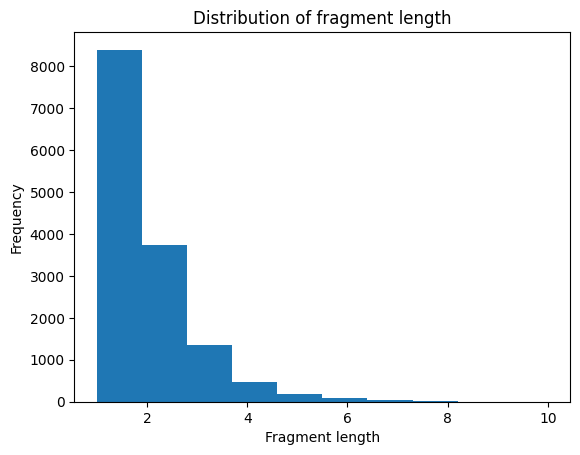

In [23]:
# detect all words that starts with Fragment in the groundtruth and print them 
fragment_words = []
for sentence in groundtruth_data["clean"]:
    words = sentence.split()
    for word in words:
        if word.startswith("FRAGMENT"):
            # remove the word FRAGMENT from the word
            word = word.replace("FRAGMENT","")
            fragment_words.append(word)

fragment_length =[]
for word in fragment_words:
    fragment_length.append(len(word))
    # print the average of the fragment length
print("The average length of the fragment is ",sum(fragment_length)/len(fragment_length))

plt.hist(fragment_length)
plt.title('Distribution of fragment length')
plt.xlabel('Fragment length')
plt.ylabel('Frequency')
plt.show()


Apply Whisper Normalizer and general clean functions 

In [ ]:

def clean_transcripts(df,col_name, is_groundtruth):
    """
    apply for sub cleaning functions to transcriptions and ground truth text 
    
    - creating three versions of cleaned text 
    - V1: remove fillers ( keeping phonological fragments)
    - V1+: remove fillers and phonological fragments
    - V2: remove fillers, phonological fragments and single word repetitions
    - V3: remove fillers, phonological fragments, single word repetitions and repeated phrases
    """
    if is_groundtruth:
        # version 1 
        new_col_name =  col_name + "_RF"
        # remove filler markers from text (this is applicable to only ground truth text in the current dataset since there are special markers for this purpose in the transcripts)
        df[new_col_name] = df[col_name].apply(lambda x: clean_version2(x) if isinstance(x, str) else x)
        print(new_col_name)
        # apply clean function to each text
        df[new_col_name] = df[new_col_name].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

        # version 1+ 
        new_col_name = col_name + "_RFF"
        # remove phono fragments and fillers from text (this is applicable to only ground truth text in the current dataset since there are special markers for this purpose in the transcripts)
        df[new_col_name] = df[col_name].apply(lambda x: clean_version3(x) if isinstance(x, str) else x)
        df[new_col_name] = df[new_col_name].apply(lambda x: clean_text(x) if isinstance(x, str) else x)
        print(new_col_name)
    else:
        new_col_name =  col_name + "_RF"
        # apply clean function to each text
        df[new_col_name] = df[col_name].apply(lambda x: clean_text(x) if isinstance(x, str) else x)
        print(new_col_name)
        # asr version 1+
        new_col_name =  col_name + "_RFF"
        print(new_col_name)
        # apply clean function to each text
        df[new_col_name] = df[col_name].apply(lambda x: clean_text(x) if isinstance(x, str) else x)
        df[new_col_name] = df[new_col_name].apply(lambda x: remove_fragments(x) if isinstance(x, str) else x)
        
    # version 2 
    new_col_name2 = col_name + "_RFFR"
    df[new_col_name2] = df[new_col_name].apply(lambda x: remove_consecutive_words(x) if isinstance(x, str) else x)
    print(new_col_name2)
    # version 3 
    new_col_name3 = col_name + "_RFFRR"
    df[new_col_name3] = df[new_col_name2].apply(lambda x: dedupe_string(x) if isinstance(x, str) else x)
    print(new_col_name3)
    return("Cleaning done")



Remove diarization patterns from RevAI transcripts 

In [25]:
# remove diarization from RevAI 
    # remove diarization pattern
def remove_diarization(text):
    pattern = r"Speaker \d+\s{2,}\d{2}:\d{2}:\d{2}"
    text = re.sub(pattern, "", text)
    return text

# # make a copy of each ASR column in asr_data 


# asr_data["RevAI"] = asr_data["RevAI"].apply(lambda x: remove_diarization(x) if isinstance(x, str) else x)

Standardize first names and last names in ground truth data and asr transcripts

In [26]:

groundtruth_data.rename(columns={selected_groundtruth_version:"groundtruth"},inplace=True)
groundtruth_data.rename(columns={"clean_v1":"original_groundtruth"},inplace=True)

# standardize groundtruth names
groundtruth_data['groundtruth']= groundtruth_data['groundtruth'].apply(lambda x: standardize_groundtruth_names(x))
groundtruth_data.to_csv("groundtruth_data.csv")

# Check columns in both dataframes
print(asr_data.columns)
print(groundtruth_data.columns)

# join groundtruth and asr dataframes
joined_transcriptions = pd.merge(groundtruth_data,asr_data,left_on="segment_name",right_on="filename",how="inner")
joined_transcriptions.head(5)

asr_columns = ["AWS","Azure","AssemblyAI","GoogleChirp","GoogleLong","GoogleTelephony","RevAI","Whisper"]
for index, row in joined_transcriptions.iterrows():
    for col in asr_columns:
        text = row[col]
        col_orig = col+"_orig"
        joined_transcriptions.loc[index,col_orig] = text
        if "firstname" in row["groundtruth"] or "lastname" in row["groundtruth"]:
            print(row['filename'])
            if isinstance(text, str):
                if col == "RevAI":
                    text = remove_diarization(text)
                tokens = text.split()
                if len(tokens) == 0:
                    continue
                for i in range(len(tokens)):
                    if firstname_dict.get(re.sub(r'[^\w\s]', '', tokens[i].capitalize())):
                        copy = tokens[i]
                        tokens[i] = firstname_dict['STANDARD_firstname']
                        print("replacing ",copy," with ",tokens[i])
                    if lastname_dict.get(re.sub(r'[^\w\s]', '', tokens[i].capitalize())):
                        copy = tokens[i]
                        tokens[i] = lastname_dict['STANDARD_lastname']
                        print("replacing ",copy," with ",tokens[i])
                text = " ".join(tokens)
                # print(text)
                joined_transcriptions.loc[index,col] = text
asr_data.to_csv("asr_data.csv")


Index(['filename', 'AWS', 'AssemblyAI', 'Azure', 'GoogleChirp', 'GoogleLong',
       'GoogleTelephony', 'RevAI', 'Whisper', 'Assembly_AI'],
      dtype='object', name='ASR')
Index(['segment_name', 'original_groundtruth', 'groundtruth', 'Group',
       'duration'],
      dtype='object')
NEURAL52-2_637827_876966.wav
replacing  Karen,  with  firstname
NEURAL52-2_637827_876966.wav
NEURAL52-2_637827_876966.wav
replacing  Karen.  with  firstname
NEURAL52-2_637827_876966.wav
NEURAL52-2_637827_876966.wav
replacing  Karen,  with  firstname
NEURAL52-2_637827_876966.wav
NEURAL52-2_637827_876966.wav
NEURAL52-2_637827_876966.wav
NEURAL74-1_246109_485176.wav
replacing  Patty  with  firstname
NEURAL74-1_246109_485176.wav
replacing  Patty  with  firstname
NEURAL74-1_246109_485176.wav
replacing  Patty  with  firstname
NEURAL74-1_246109_485176.wav
replacing  patty  with  firstname
NEURAL74-1_246109_485176.wav
replacing  Patty  with  firstname
NEURAL74-1_246109_485176.wav
NEURAL74-1_246109_485176.wav
rep

Clean ASR transcripts 

In [27]:
test_string = "hi mu mushroom" # test two character fragments
print(remove_fragments(test_string)) # should return "hi mushroom"
test_string = "hi mus mushroom" # test three character fragments
print(remove_fragments(test_string)) # should return "hi mus mushroom"

hi mushroom
hi mus mushroom


Standardize ground truth

In [28]:
# iterate through each column in asr_data and clean the text
# standardize names first 
# groundtruth_data['groundtruth'] = groundtruth_data['groundtruth'].apply(lambda x: standardize_names(x) if isinstance(x, str) else x)
clean_transcripts( df =joined_transcriptions, col_name="groundtruth",is_groundtruth=True)


groundtruth_RFFR
groundtruth_RFFRR


'Cleaning done'

Standardize ASR transcripts

In [29]:

# groundtruth_data.to_csv("groundtruth_data.csv")
# df  = pd.DataFrame(test_groundtruth)

for col in asr_columns:
        # asr_data[col] = asr_data[col].apply(lambda x: standardize_names(x) if isinstance(x, str) else x)
    clean_transcripts(df = joined_transcriptions, col_name=col,is_groundtruth=False)
    print("Cleaning done for ",col)
None

before modify number case:  Two powers and 2000 and 3, 2008.
after modify number case:  Two powers and 2003 2008.
AWS_RF
AWS_RFF
before modify number case:  Two powers and 2000 and 3, 2008.
after modify number case:  Two powers and 2003 2008.
AWS_RFFR
AWS_RFFRR
Cleaning done for  AWS
Azure_RF
Azure_RFF
Azure_RFFR
Azure_RFFRR
Cleaning done for  Azure
AssemblyAI_RF
AssemblyAI_RFF
AssemblyAI_RFFR
AssemblyAI_RFFRR
Cleaning done for  AssemblyAI
GoogleChirp_RF
GoogleChirp_RFF
GoogleChirp_RFFR
GoogleChirp_RFFRR
Cleaning done for  GoogleChirp
GoogleLong_RF
GoogleLong_RFF
GoogleLong_RFFR
GoogleLong_RFFRR
Cleaning done for  GoogleLong
GoogleTelephony_RF
GoogleTelephony_RFF
GoogleTelephony_RFFR
GoogleTelephony_RFFRR
Cleaning done for  GoogleTelephony
RevAI_RF
RevAI_RFF
RevAI_RFFR
RevAI_RFFRR
Cleaning done for  RevAI
Whisper_RF
Whisper_RFF
Whisper_RFFR
Whisper_RFFRR
Cleaning done for  Whisper


In [30]:
test = "hi hi hi i dont know know know i dont know i dont know"
test1 = "and then then we and then we"
test2 = remove_consecutive_words(test1)
test3 = dedupe_string(test2)
print(test,"-->v2-->",remove_consecutive_words(test))
print(test,"-->v3-->",dedupe_string(test))
print(test,"--v2+v3-->",dedupe_string(remove_consecutive_words(test)))

hi hi hi i dont know know know i dont know i dont know -->v2--> hi i dont know i dont know i dont know
hi hi hi i dont know know know i dont know i dont know -->v3--> hi i dont i dont know
hi hi hi i dont know know know i dont know i dont know --v2+v3--> hi i dont know


In [31]:
print(joined_transcriptions.columns)
# detect column names that have orig in them
orig_columns = [col for col in joined_transcriptions.columns if "_orig" in col]

# filter out the columns in google long and goolge telephony
orig_columns = [col for col in orig_columns if "GoogleLong" not in col and "GoogleTelephony" not in col]
print(orig_columns)

Index(['segment_name', 'original_groundtruth', 'groundtruth', 'Group',
       'duration', 'filename', 'AWS', 'AssemblyAI', 'Azure', 'GoogleChirp',
       'GoogleLong', 'GoogleTelephony', 'RevAI', 'Whisper', 'Assembly_AI',
       'AWS_orig', 'Azure_orig', 'AssemblyAI_orig', 'GoogleChirp_orig',
       'GoogleLong_orig', 'GoogleTelephony_orig', 'RevAI_orig', 'Whisper_orig',
       'groundtruth_RF', 'groundtruth_RFF', 'groundtruth_RFFR',
       'groundtruth_RFFRR', 'AWS_RF', 'AWS_RFF', 'AWS_RFFR', 'AWS_RFFRR',
       'Azure_RF', 'Azure_RFF', 'Azure_RFFR', 'Azure_RFFRR', 'AssemblyAI_RF',
       'AssemblyAI_RFF', 'AssemblyAI_RFFR', 'AssemblyAI_RFFRR',
       'GoogleChirp_RF', 'GoogleChirp_RFF', 'GoogleChirp_RFFR',
       'GoogleChirp_RFFRR', 'GoogleLong_RF', 'GoogleLong_RFF',
       'GoogleLong_RFFR', 'GoogleLong_RFFRR', 'GoogleTelephony_RF',
       'GoogleTelephony_RFF', 'GoogleTelephony_RFFR', 'GoogleTelephony_RFFRR',
       'RevAI_RF', 'RevAI_RFF', 'RevAI_RFFR', 'RevAI_RFFRR', 'Whisper_RF

In [ ]:

# sort data in the following order: filename, groundtruth, groundtruth_V1, groundtruth_V2, groundtruth_V3, ASR, ASR_V1, ASR_V2, ASR_V3
column_order =['filename','segment_name','duration','Group',
               'original_groundtruth','groundtruth','groundtruth_RF','groundtruth_RFF','groundtruth_RFFR','groundtruth_RFFRR',
               'AWS_orig','AWS_RF','AWS_RFF','AWS_RFFR','AWS_RFFRR',
                'Azure_orig','Azure_RF','Azure_RFF','Azure_RFFR','Azure_RFFRR',

               'GoogleChirp_orig','GoogleChirp_RF','GoogleChirp_RFF','GoogleChirp_RFFR','GoogleChirp_RFFRR',
               # 'GoogleTelephony_orig','GoogleTelephony_RF','GoogleTelephony_RFF','GoogleTelephony_RFFR','GoogleTelephony_RFFRR',
               # 'GoogleLong_orig','GoogleLong_RF','GoogleLong_RFF','GoogleLong_RFFR','GoogleLong_RFFRR',
               'RevAI_orig','RevAI_RF','RevAI_RFF','RevAI_RFFR','RevAI_RFFRR',
               'Whisper_orig','Whisper_RF','Whisper_RFF','Whisper_RFFR','Whisper_RFFRR',
               'AssemblyAI_orig','AssemblyAI_RF','AssemblyAI_RFF','AssemblyAI_RFFR','AssemblyAI_RFFRR']
joined_transcriptions = joined_transcriptions[column_order]
joined_transcriptions.columns

# output cleaned versions of both ground truth and ASR transcriptions
date=str(datetime.datetime.now().date())
joined_transcriptions.to_csv(date+"_joined_transcripts.csv")


In [33]:
del groundtruth_data
del asr_data

In [34]:
# column names 
print(joined_transcriptions.columns)

Index(['filename', 'segment_name', 'duration', 'Group', 'original_groundtruth',
       'groundtruth', 'groundtruth_RF', 'groundtruth_RFF', 'groundtruth_RFFR',
       'groundtruth_RFFRR', 'AWS_orig', 'AWS_RF', 'AWS_RFF', 'AWS_RFFR',
       'AWS_RFFRR', 'Azure_orig', 'Azure_RF', 'Azure_RFF', 'Azure_RFFR',
       'Azure_RFFRR', 'GoogleChirp_orig', 'GoogleChirp_RF', 'GoogleChirp_RFF',
       'GoogleChirp_RFFR', 'GoogleChirp_RFFRR', 'RevAI_orig', 'RevAI_RF',
       'RevAI_RFF', 'RevAI_RFFR', 'RevAI_RFFRR', 'Whisper_orig', 'Whisper_RF',
       'Whisper_RFF', 'Whisper_RFFR', 'Whisper_RFFRR', 'AssemblyAI_orig',
       'AssemblyAI_RF', 'AssemblyAI_RFF', 'AssemblyAI_RFFR',
       'AssemblyAI_RFFRR'],
      dtype='object')


In [35]:
# select cleaned transcripts columns for WER calculation
cleaned_asr_list = ["Whisper_RF", "Whisper_RFF", "Whisper_RFFR", "Whisper_RFFRR",
                    # "WhisperDistil_RF", "WhisperDistil_V2", "WhisperDistil_RFFRR",
                    "GoogleChirp_RF", "GoogleChirp_RFF","GoogleChirp_RFFR", "GoogleChirp_RFFRR",
                    # "GoogleTelephony_RF","GoogleTelephony_V1+", "GoogleTelephony_V2", "GoogleTelephony_RFFRR",
                    # "GoogleLong_RF", "GoogleLong_V1+","GoogleLong_V2", "GoogleLong_RFFRR",
                    "RevAI_RF","RevAI_RFF", "RevAI_RFFR", "RevAI_RFFRR",
                    "AWS_RF","AWS_RFF", "AWS_RFFR", "AWS_RFFRR",
                    "Azure_RF","Azure_RFF", "Azure_RFFR", "Azure_RFFRR",
                    "AssemblyAI_RF", "AssemblyAI_RFF","AssemblyAI_RFFR", "AssemblyAI_RFFRR",
                    ]

wer_orig = pd.DataFrame(wer_calc(joined_transcriptions, 'original_groundtruth',orig_columns))

selected_asr_list = [item for item in cleaned_asr_list if item.endswith("RF")]
print(selected_asr_list)
wer_rates0 = pd.DataFrame(wer_calc(wer_orig,'groundtruth_RFF',selected_asr_list))

# calculate WER for each cleaned ASR transcript
selected_asr_list = [item for item in cleaned_asr_list if item.endswith("RF")]
print(selected_asr_list)
wer_rates1 = pd.DataFrame(wer_calc(wer_rates0,'groundtruth_RF',selected_asr_list))

selected_asr_list = [item for item in cleaned_asr_list if item.endswith("RFFR")]
print(selected_asr_list)
wer_rates2 = pd.DataFrame(wer_calc(wer_rates1,'groundtruth_RFFR',selected_asr_list))
print(wer_rates2.columns.values)

selected_asr_list = [item for item in cleaned_asr_list if item.endswith("RFFRR")]
print(selected_asr_list)
wer_rates3 = pd.DataFrame(wer_calc(wer_rates2,'groundtruth_RFFRR',selected_asr_list))
print(wer_rates3.columns.values)

# remove groundtruth column 
wer_rates3 = wer_rates3.drop(columns=["groundtruth"])

['Whisper_RF', 'GoogleChirp_RF', 'RevAI_RF', 'AWS_RF', 'Azure_RF', 'AssemblyAI_RF']
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
['Whisper_RF', 'GoogleChirp_RF', 'RevAI_RF', 'AWS_RF', 'Azure_RF', 'AssemblyAI_RF']
['Whisper_RFFR', 'GoogleChirp_RFFR', 'RevAI_RFFR', 'AWS_RFFR', 'Azure_RFFR', 'AssemblyAI_RFFR']
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground truth is empty
ground tru

In [36]:
wer_rates3.columns

Index(['filename', 'segment_name', 'duration', 'Group', 'original_groundtruth',
       'groundtruth_RF', 'groundtruth_RFF', 'groundtruth_RFFR',
       'groundtruth_RFFRR', 'AWS_orig', 'AWS_RF', 'AWS_RFF', 'AWS_RFFR',
       'AWS_RFFRR', 'Azure_orig', 'Azure_RF', 'Azure_RFF', 'Azure_RFFR',
       'Azure_RFFRR', 'GoogleChirp_orig', 'GoogleChirp_RF', 'GoogleChirp_RFF',
       'GoogleChirp_RFFR', 'GoogleChirp_RFFRR', 'RevAI_orig', 'RevAI_RF',
       'RevAI_RFF', 'RevAI_RFFR', 'RevAI_RFFRR', 'Whisper_orig', 'Whisper_RF',
       'Whisper_RFF', 'Whisper_RFFR', 'Whisper_RFFRR', 'AssemblyAI_orig',
       'AssemblyAI_RF', 'AssemblyAI_RFF', 'AssemblyAI_RFFR',
       'AssemblyAI_RFFRR', 'original_groundtruth_AWS_orig_wer',
       'original_groundtruth_Azure_orig_wer',
       'original_groundtruth_AssemblyAI_orig_wer',
       'original_groundtruth_GoogleChirp_orig_wer',
       'original_groundtruth_RevAI_orig_wer',
       'original_groundtruth_Whisper_orig_wer',
       'groundtruth_RFF_Whisper_RF_w

In [37]:
# save dataframe to zip csv 
csv_buffer = StringIO()
wer_rates3.to_csv(csv_buffer,index=False)


with zipfile.ZipFile(date+"_WER_Results.zip", 'w') as zip_file:
    zip_file.writestr(date+'WER_Results.csv', csv_buffer.getvalue())


# # output WER result to csv
# wer_rates3.to_csv(date+"_WER_Results.csv")
